In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os import path
import sys
sys.path.insert(0, path.abspath('../'))

from src.mcmc import Chain
from src import parse_model_parameter_file

In [2]:
def read_pkl_file_chain(PATH_pklfile_chains):
    with open(PATH_pklfile_chains, 'rb') as pf:
        data = pickle.load(pf)
    
    chain = data['chain']
    #print(data['log_likelihood'])
    print(chain.shape)
    n_walkers = chain.shape[0]
    n_parameters = chain.shape[1]

    return n_walkers, n_parameters, data['chain']

In [21]:
#loading the chain file
#TODO WHAT IS THIS PARAMETERS??
dNcencut = 7  
vncencut = 6

nameStr = "Name"
#nwalkers, nsteps, ndim, chain_pkl = read_pkl_file_chain(path.join("mcmc", "chain.pkl"))[3]

nsteps, ndim, chain_pkl = read_pkl_file_chain(path.join("/home/niklas/Desktop/lustre/good_bayes/inference/actual/mcmc_val/no_log/no_pca/PCGP", "data:allenergies:05:base:noetacut:nostarptcut_nolog_nopca_PCGP_closure.pkl"))
chain = np.nan_to_num(chain_pkl)

(47697, 15)


In [22]:
# get the posterior parameters
samples = chain.reshape(-1, ndim)

# print out the MAP parameters
results = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
              zip(*np.percentile(samples, [16, 50, 84], axis=0)))
mapParam = []
for ipar, par in enumerate(list(results)):
    print("%s = %.4f^{+%.4f}_{-%.4f}" % (
        ipar, par[0], par[1], par[2]))
    mapParam.append(par[0])

# define the relevant mcmc object
exp_path = "/home/niklas/Desktop/lustre/good_bayes/inference/actual/latent_test/data:allenergies:05:base:noetacut:nostarptcut.pkl"
model_par = '/home/niklas/Desktop/lustre/good_bayes/inference/training_points/configs/config_AuAu_200_bulk_scan_central.yaml'
mymcmc = Chain(expdata_path=exp_path, model_parafile=model_par)
emuPath=["/home/niklas/Desktop/lustre/good_bayes/inference/actual/emulator_val/no_log/no_pca/PCGP/data:allenergies:05:base:noetacut:nostarptcut_nolog_nopca_PCGP"]

mymcmc.loadEmulator(emuPath)



0 = 0.8824^{+0.0189}_{-0.0205}
1 = 0.8354^{+0.6524}_{-0.5407}
2 = -0.0699^{+0.4974}_{-0.7703}
3 = 0.6127^{+0.1000}_{-0.1812}
4 = 0.1049^{+0.0146}_{-0.0155}
5 = 0.4297^{+1.1520}_{-0.7863}
6 = 0.0147^{+0.1451}_{-0.1146}
7 = 1.5174^{+0.3881}_{-0.4833}
8 = 2.0068^{+0.0641}_{-0.0524}
9 = 0.1584^{+0.0370}_{-0.0204}
10 = 0.0443^{+0.0170}_{-0.0227}
11 = 22.9454^{+12.1679}_{-15.3753}
12 = 0.0532^{+0.0340}_{-0.0346}
13 = 0.0795^{+0.0486}_{-0.0480}
14 = 0.9606^{+0.0865}_{-0.0813}
[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from /home/niklas/Desktop/lustre/good_bayes/inference/training_points/configs/config_AuAu_200_bulk_scan_central.yaml ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from /home/niklas/Desktop/lustre/good_bayes/inference/actual/latent_test/data:allenergies:05:base:noetacut:nostarptcut.pkl ...
[INFO][mcmc] Experimental dataset size: 150
[I

In [23]:
# setup the MCMC Chain
#-> is it correct to set up a new one here?
#yes, because we just use the emulator
rng = np.random.default_rng()
#print(samples.shape)
sampleIdxList = rng.choice(samples.shape[0], 3000, replace=False) #choose 15 random samples for parameter prediction
posteriorSamples = samples[sampleIdxList, :]
#print(posteriorSamples.shape)
postPred = mymcmc._predict(posteriorSamples) #convert the 15 parameters to posterior predictons
postPred = postPred[0].transpose()
nsamples = postPred.shape[1]
#print(postPred.shape)
expData = mymcmc._read_in_exp_data_pickle(exp_path)
with open(exp_path, "rb") as fp:
        dataDict = pickle.load(fp)
        #print(dataDict)
        parameters=dataDict[499]["parameter"]
print(parameters)

[INFO][mcmc] Experimental dataset size: 150
[0.8637, 0.42725000000000013, 0.07525000000000004, 0.4895, 0.124223, 0.7389999999999999, 0.29235, 1.634, 2.0540000000000003, 0.1582, 0.0354, 25.7405, 0.005855, 0.11849999999999998, 0.9556]


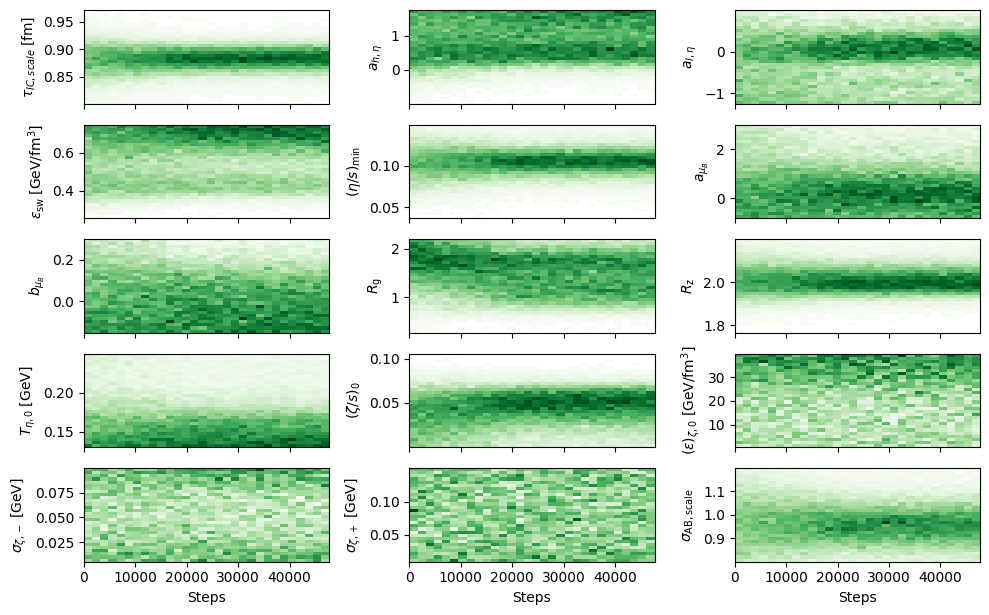

In [24]:
#TODO is there really no convergence?
#emulators are good, PCA consistently worse for them (issue?)
#log could be an issue, but his log has some problem with the log_likelihood
#it shows that convergence is possible, but it is not clear why it didn't happen with others also
#TODO adapt
#Convergence still not fixed. Is the problem in the visualisation? Why are some regions not sampled into at all?
#TODO debug with chatty? use other MCMC?
# WHY Is not the whole region covered?
#Plan: use first other mcmc, because I have to figure out why not whole region covered
prior_ranges = [
    (0.8,1.5),
    (-1,1.75),
    (-1.25,1),
    (0.25,0.75),
    (0.001,0.15),
    (-0.8,3),
    (-0.15,0.3),
    (0.2,2.2),
    (0.2,2.2),
    (0.13,0.25),
    (0,0.2),
    (0.5,40),
    (0.005,0.1),
    (0.01,0.15),
    (0.8,1.2),
] 
PARAMETER_NAMES = [
    r'$\tau_{IC,scale}\;[{\rm fm}]$',
    r'$a_{h,\eta}$',
    r'$a_{l,\eta}$',
    r'$\epsilon_{\rm sw}\;[{\rm GeV/fm^3}]$',
    r'$(\eta/s)_{\rm min}$',
    r'$a_{\mu_B}$', #etsscale_mub
    r'$b_{\mu_B}$',#etasshiftmub
    r'$R_{\rm g}$',
    r'$R_{\rm z}$',
    r'$T_{\eta, \rm 0}\;[{\rm GeV}]$',
    r'$(\zeta/s)_{\rm 0}$',
    r'$(\epsilon)_{\zeta,\rm 0 }\;[{\rm GeV/fm^3}]$',
    r'$\sigma_{\zeta, \rm -}\;[{\rm GeV}]$',
    r'$\sigma_{\zeta, \rm +}\;[{\rm GeV}]$',
    r'$\sigma_{\rm AB, scale}$'
]
def plot_chain_histogram(n_parameters, data_array, true_values=None):
    num_columns = 3

    # Calculate the number of rows needed based on the number of parameters and columns
    num_rows = (n_parameters + num_columns - 1) // num_columns

    # Define the height of each subplot
    subplot_height = 1.25

    # Calculate the total height of the figure
    total_height = subplot_height * num_rows

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(10, total_height), sharex=False)
    axs = axs.flatten()

    for param_index in range(n_parameters):
        # Create a 2D histogram
        concatenated_data = data_array[ :, param_index].reshape(-1)
        #print(concatenated_data)
        hist, xedges, yedges = np.histogram2d(np.arange(nsteps), concatenated_data.flatten(), bins=30)
        hist = np.ma.masked_where(hist == 0, hist)  # Mask empty bins
        im = axs[param_index].pcolormesh(xedges, yedges, hist.T, cmap='Greens')

        if true_values is not None:
            axs[param_index].axhline(true_values[param_index], color='k', linestyle='--', alpha=0.5)

        axs[param_index].set_ylabel(PARAMETER_NAMES[param_index])
        axs[param_index].set_xlim([0., max(xedges)])
        axs[param_index].set_ylim([np.min( concatenated_data.flatten()), np.max( concatenated_data.flatten())])
        #axs[param_index].set_ylim([-2,2])
    # Specify indices for which to display x-axis labels
    indices_with_labels = [12, 13, 14]

    # Set x-axis labels and numbers for specified indices
    for i, ax in enumerate(axs):
        if i in indices_with_labels:
            ax.set_xlabel('Steps')
        else:
            ax.set_xticklabels([])

    # Hide the empty subplots
    for i in range(n_parameters, num_columns * num_rows):
        fig.delaxes(axs[i])

    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

plot_chain_histogram( 15, chain, true_values=None)

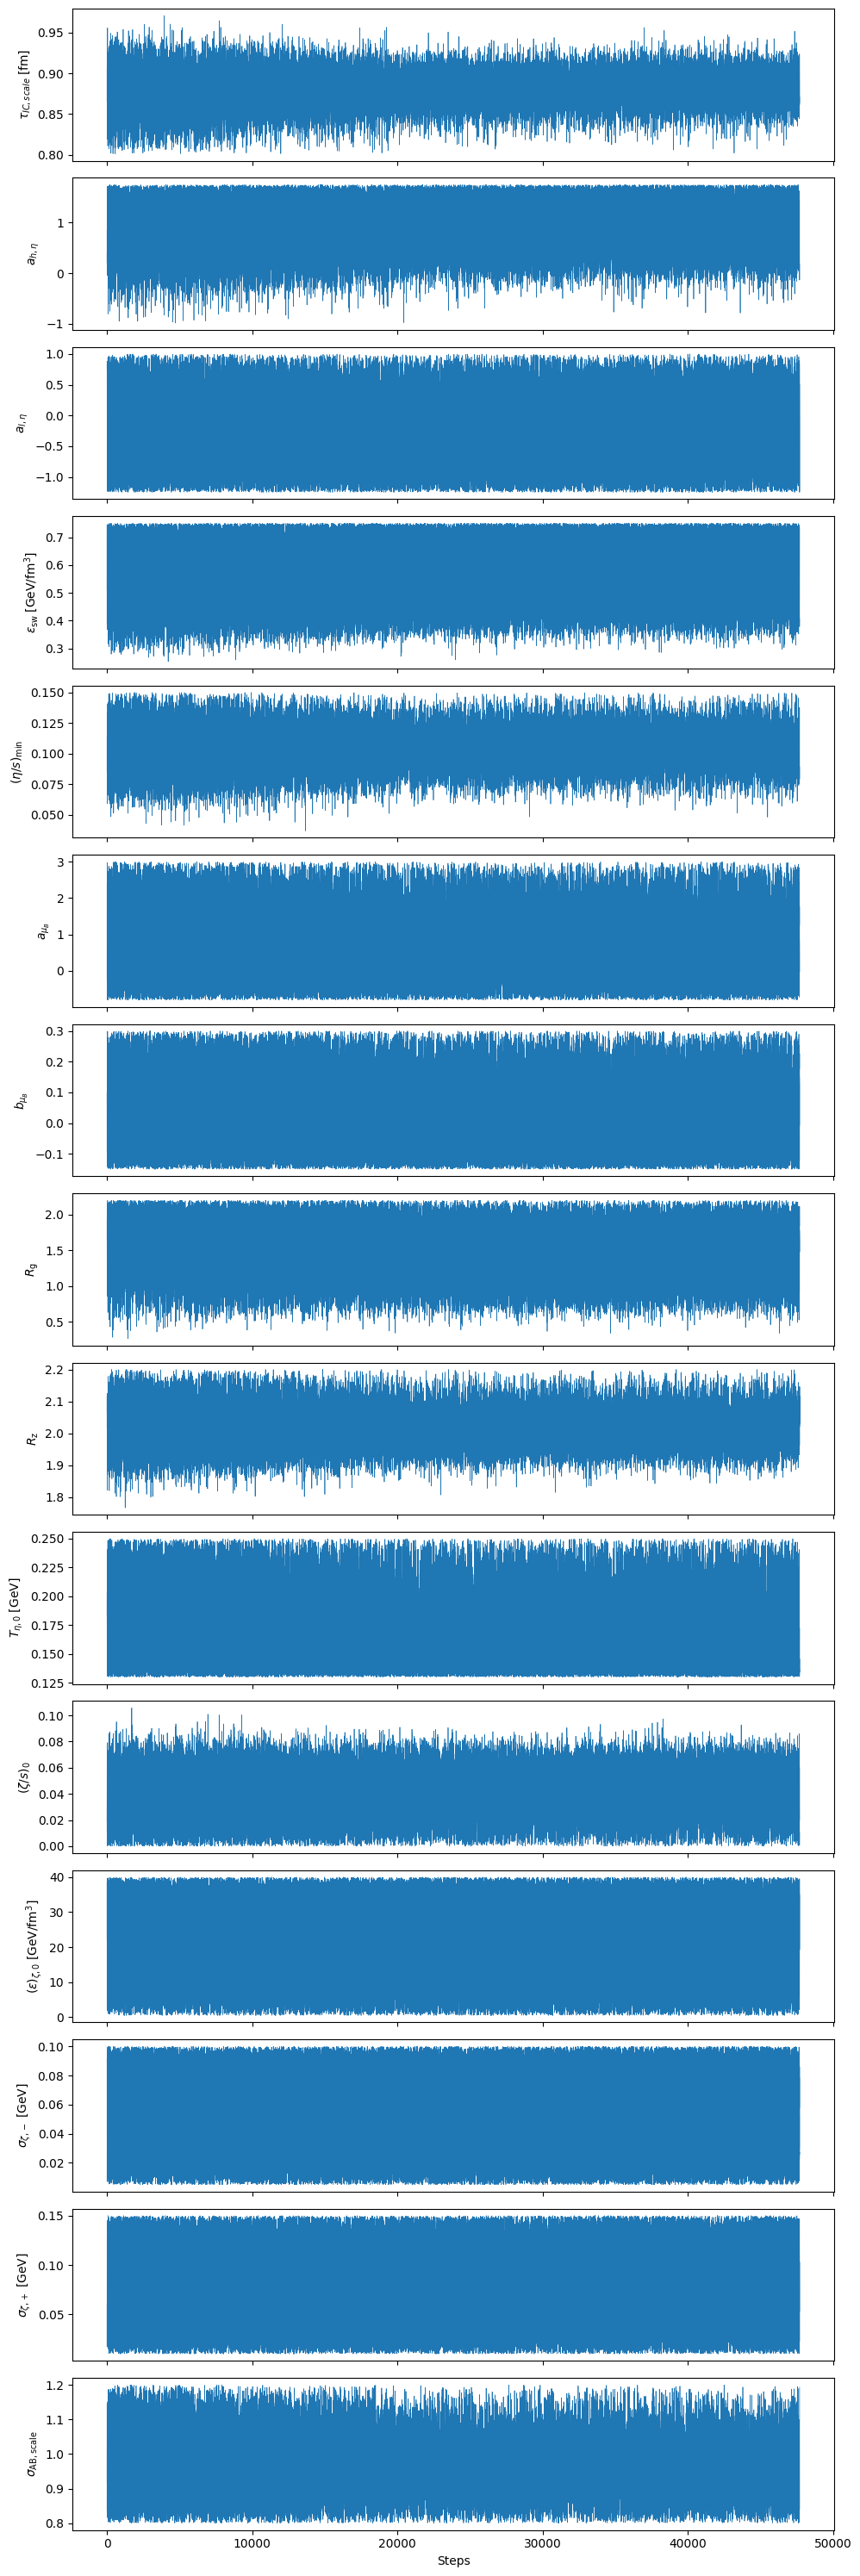

In [25]:
def plot_trace(chain, param_names):
    n_params = chain.shape[1]
    fig, axs = plt.subplots(n_params, figsize=(10, 2 * n_params), sharex=True)
    for i in range(n_params):
        axs[i].plot(chain[:, i], lw=0.5)
        axs[i].set_ylabel(param_names[i])
    axs[-1].set_xlabel("Steps")
    plt.tight_layout()
    plt.show()

plot_trace(chain, PARAMETER_NAMES)

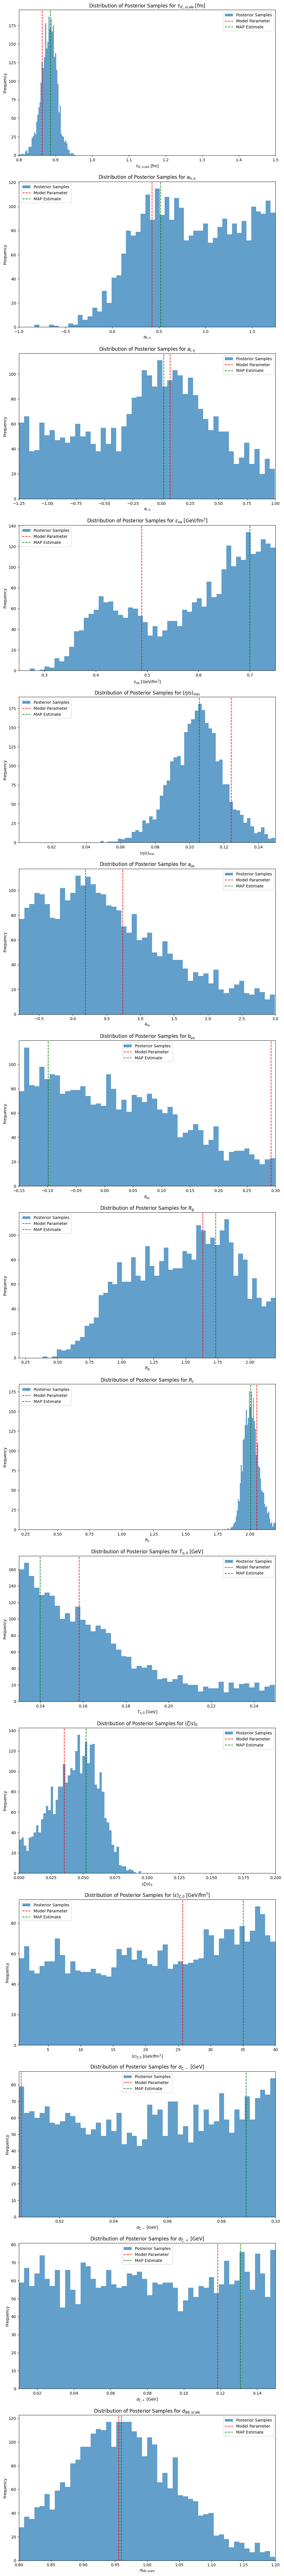

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode
from scipy.stats import gaussian_kde
#TODO the distribution is flat, something is odd here
#also what is happening to the model parameter, why out of distribution

def extract_model_parameters():
    # Placeholder for actual model parameters extraction logic
    return parameters

def calculate_map_estimates(posteriorSamples):
    map_estimates = []
    for i in range(posteriorSamples.shape[1]):
        kde = gaussian_kde(posteriorSamples[:, i])
        x_vals = np.linspace(np.min(posteriorSamples[:, i]), np.max(posteriorSamples[:, i]), 1000)
        kde_vals = kde(x_vals)
        mode_idx = np.argmax(kde_vals)
        map_estimates.append(x_vals[mode_idx])
    return map_estimates

def plot_distribution_of_posterior_samples(posteriorSamples, modelParameters, mapEstimates):
    n_parameters = posteriorSamples.shape[1]
    
    fig, axes = plt.subplots(n_parameters, 1, figsize=(10, 6 * n_parameters))
    
    for i in range(n_parameters):
        ax = axes[i] if n_parameters > 1 else axes
        ax.hist(posteriorSamples[:, i], bins=50, alpha=0.7, label='Posterior Samples')
        ax.axvline(modelParameters[i], color='r', linestyle='--', label='Model Parameter')
        ax.axvline(mapEstimates[i], color='g', linestyle='--', label='MAP Estimate')
        ax.set_xlabel(PARAMETER_NAMES[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of Posterior Samples for {PARAMETER_NAMES[i]}')
        ax.set_xlim([prior_ranges[i][0], prior_ranges[i][1]])
        ax.legend()
    
    plt.tight_layout()
    plt.savefig("closure_05.png")
    plt.show()

# Assuming posteriorSamples is already defined
#posteriorSamples = np.random.randn(1000, 15)  # Example posterior samples for demonstration

# Extract model parameters
modelParameters = extract_model_parameters()

# Calculate MAP estimates
mapEstimates = calculate_map_estimates(posteriorSamples)

# Call the plotting function
plot_distribution_of_posterior_samples(posteriorSamples, modelParameters, mapEstimates)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

def extract_model_parameters():
    # Placeholder for actual model parameters extraction logic
    return parameters

def calculate_map_estimates(posteriorSamples):
    # Calculate the MAP (Maximum A Posteriori) estimate for each parameter
    map_estimates = np.max(posteriorSamples, axis=0)
    return map_estimates.tolist()  

def plot_distribution_of_posterior_samples(posteriorSamples, modelParameters, mapEstimates):
    n_parameters = posteriorSamples.shape[1]
    
    fig, axes = plt.subplots(n_parameters, 1, figsize=(10, 6 * n_parameters))
    
    for i in range(n_parameters):
        ax = axes[i] if n_parameters > 1 else axes
        ax.hist(posteriorSamples[:, i], bins=50, alpha=0.7, label='Posterior Samples')
        ax.axvline(modelParameters[i], color='r', linestyle='--', label='Model Parameter')
        ax.axvline(mapEstimates[i], color='g', linestyle='--', label='MAP Estimate')
        ax.set_xlabel(f'Parameter {i+1}')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of Posterior Samples for Parameter {i+1}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming posteriorSamples is already defined
#posteriorSamples = np.random.randn(1000, 15)  # Example posterior samples for demonstration

# Extract model parameters
modelParameters = extract_model_parameters()

# Calculate MAP estimates
mapEstimates = calculate_map_estimates(posteriorSamples)

# Call the plotting function
plot_distribution_of_posterior_samples(posteriorSamples, modelParameters, mapEstimates)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming posteriorSamples and postPred are already defined

def plot_predicted_vs_input(posteriorSamples, postPred):
    n_parameters = posteriorSamples.shape[1]
    predicted_mean = postPred.mean(axis=1)
    
    if posteriorSamples.shape[0] != predicted_mean.shape[0]:
        raise ValueError("posteriorSamples and postPred must have the same number of rows.")
    
    fig, axes = plt.subplots(n_parameters, 1, figsize=(10, 6 * n_parameters))
    
    for i in range(n_parameters):
        ax = axes[i] if n_parameters > 1 else axes
        ax.scatter(posteriorSamples[:, i], predicted_mean, alpha=0.5, label='Predicted vs Input')
        ax.set_xlabel(f'Input Parameter {i+1}')
        ax.set_ylabel('Predicted Value')
        ax.set_title(f'Predicted vs Input Parameter {i+1}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_residuals_vs_input(posteriorSamples, postPred):
    predicted_mean = postPred.mean(axis=1)
    
    if posteriorSamples.shape[0] != predicted_mean.shape[0]:
        raise ValueError("posteriorSamples and postPred must have the same number of rows.")
    
    residuals = predicted_mean - posteriorSamples
    n_parameters = posteriorSamples.shape[1]
    fig, axes = plt.subplots(n_parameters, 1, figsize=(10, 6 * n_parameters))
    
    for i in range(n_parameters):
        ax = axes[i] if n_parameters > 1 else axes
        ax.scatter(posteriorSamples[:, i], residuals[:, i], alpha=0.5, label='Residuals vs Input')
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xlabel(f'Input Parameter {i+1}')
        ax.set_ylabel('Residual')
        ax.set_title(f'Residuals vs Input Parameter {i+1}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_distribution_of_predictions(postPred):
    plt.figure(figsize=(10, 6))
    plt.hist(postPred.flatten(), bins=50, alpha=0.7, label='Predicted Data')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Values')
    plt.legend()
    plt.show()

# Call the plotting functions
plot_predicted_vs_input(posteriorSamples, postPred)
plot_residuals_vs_input(posteriorSamples, postPred)
plot_distribution_of_predictions(postPred)

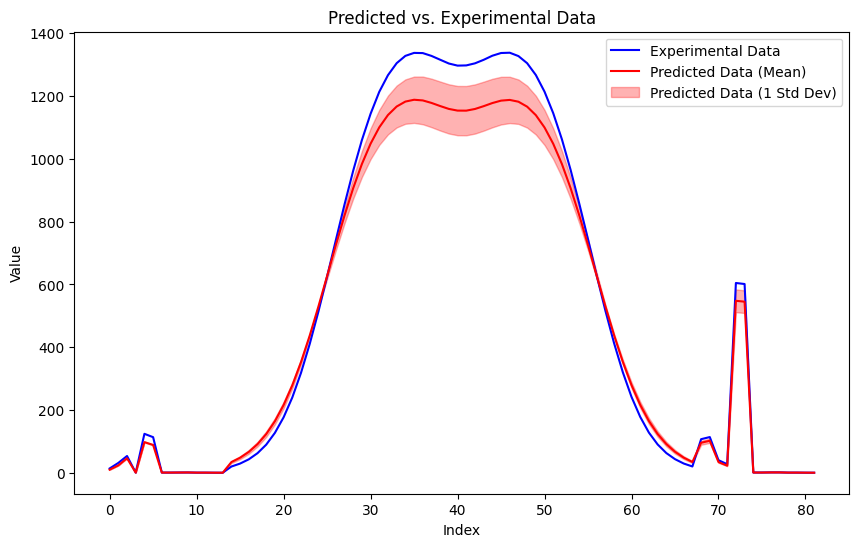

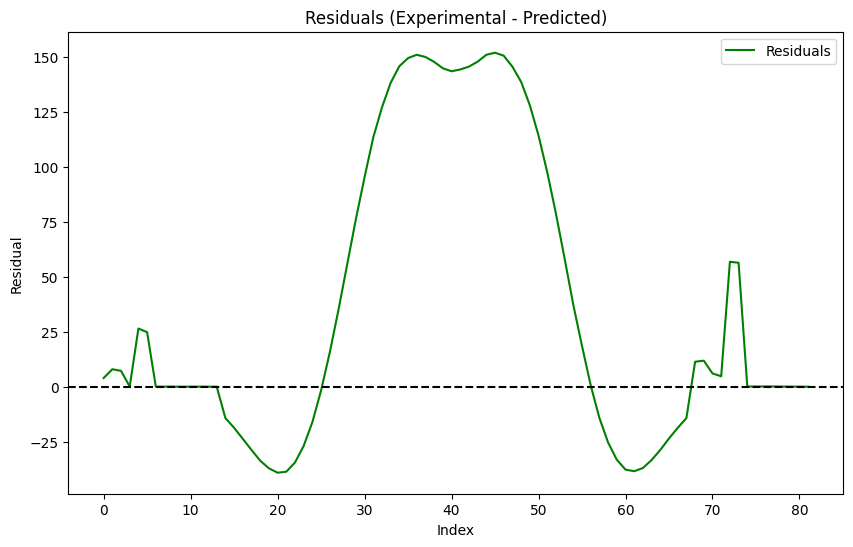

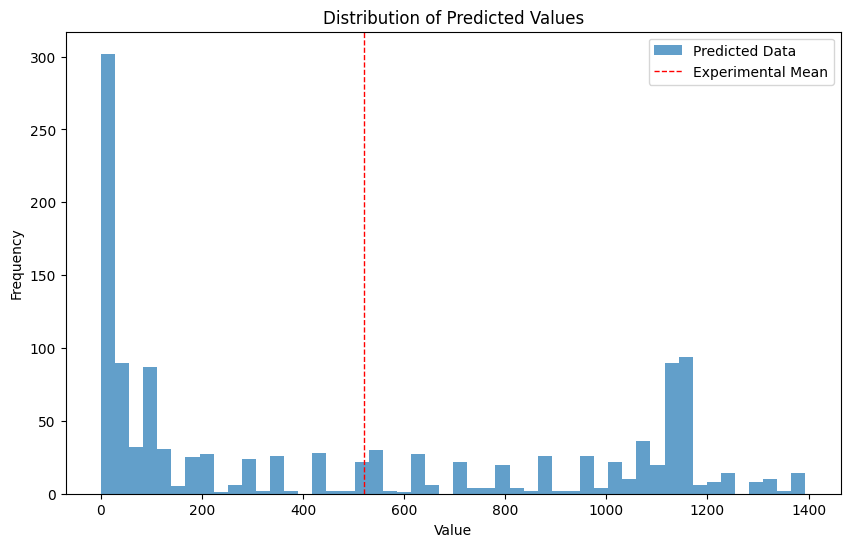

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# # Assuming expData and postPred are already defined
# # Plot Predicted vs. Experimental Data
# plt.figure(figsize=(10, 6))
# plt.plot(expData[0].flatten(), label='Experimental Data', color='blue')
# plt.plot(postPred.mean(axis=1), label='Predicted Data (Mean)', color='red')
# plt.fill_between(range(len(expData[0].flatten())), 
#                  postPred.mean(axis=1) - postPred.std(axis=1), 
#                  postPred.mean(axis=1) + postPred.std(axis=1), 
#                  color='red', alpha=0.3, label='Predicted Data (1 Std Dev)')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Predicted vs. Experimental Data')
# plt.legend()
# plt.show()

# # Plot Residuals
# residuals = expData[0].flatten() - postPred.mean(axis=1)
# plt.figure(figsize=(10, 6))
# plt.plot(residuals, label='Residuals', color='green')
# plt.axhline(0, color='black', linestyle='--')
# plt.xlabel('Index')
# plt.ylabel('Residual')
# plt.title('Residuals (Experimental - Predicted)')
# plt.legend()
# plt.show()

# # Plot Distribution of Predictions
# plt.figure(figsize=(10, 6))
# plt.hist(postPred.flatten(), bins=50, alpha=0.7, label='Predicted Data')
# plt.axvline(expData[0].mean(), color='red', linestyle='dashed', linewidth=1, label='Experimental Mean')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Distribution of Predicted Values')
# plt.legend()
# plt.show()

ValueError: 'x' and 'y' must have the same size

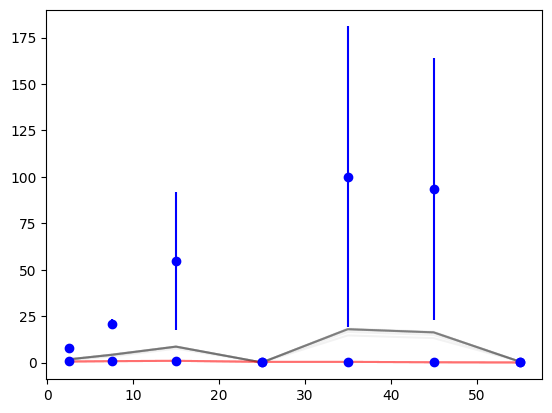

In [17]:
#the closure test plotting functions

colorList = ['k', 'r', 'g', 'y', 'c']
cenList = np.array([2.5, 7.5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
#this plots expdata and the posterior samples as function of centrality. we have to reformulate this
# dN/dy
fig = plt.figure()
for ipart in range(4):
    plt.errorbar(cenList[:dNcencut],
                 expData[0][:, ipart*dNcencut:(ipart+1)*dNcencut].flatten(),
                 expData[1][ipart*dNcencut:(ipart+1)*dNcencut, ipart*dNcencut:(ipart+1)*dNcencut].diagonal(),
                 marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:dNcencut],
                 postPred[ipart*dNcencut:(ipart+1)*dNcencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.yscale('log')
plt.xlabel("Centrality(%)", fontsize = 12)
plt.ylabel("log(dN/dy)", fontsize = 13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("dNdy200_{}.pdf".format(nameStr))

# # mean pT
# offset = 4*dNcencut
# fig = plt.figure()
# for ipart in range(4):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylim([0, 1.5])
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("meanpT200_{}.pdf".format(nameStr))

# # vn
# offset += 4*dNcencut
# fig = plt.figure()
# for ipart in range(2):
#     plt.errorbar(cenList[:vncencut],
#              expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
#              expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:vncencut],
#                  postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylabel(r"$v_n$", fontsize = 13 )
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.ylim([0., 0.12])
# plt.savefig("vn200_{}.pdf".format(nameStr))

# # dNdeta
# Nrap = 34
# rapArr = np.linspace(-3.3, 3.3, Nrap) #rapidity range different for current simulation, -3.3 to 3.3
# offset += 2*vncencut
# fig = plt.figure()
# for ipart in range(5):
#     plt.errorbar(rapArr,
#              expData[0][:,offset+ipart*Nrap:offset+(ipart+1)*Nrap].flatten(),
#              expData[1][offset+ipart*Nrap:offset+(ipart+1)*Nrap, offset+ipart*Nrap:offset+(ipart+1)*Nrap].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(rapArr,
#                  postPred[offset+ipart*Nrap:offset+(ipart+1)*Nrap, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)

# plt.ylabel(r"$dN^{\rm ch}/d\eta$", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("dNdeta200_{}.pdf".format(nameStr))

# # v2(eta)
# offset += 5*Nrap
# v2rapArr = np.array([-4.90, -4.16, -3.41, -2.70, -2.25, -1.75, -1.26, -0.76,
#                      -0.3, 0.3, 0.76, 1.26, 1.75, 2.25, 2.70, 3.41, 4.16, 4.94])
# v2Nrap = v2rapArr.shape[0] - 4

# fig = plt.figure()
# ax = plt.axes([0.12, 0.12, 0.85, 0.85])
# plt.errorbar(v2rapArr[2:-2],
#              expData[0][:, offset : (offset+v2Nrap)].flatten(),
#              expData[1][offset:offset+v2Nrap, offset:offset+v2Nrap].diagonal(),
#              marker='o', color='b', linestyle='')
# for i in range(nsamples):
#     plt.plot(v2rapArr[2:-2],
#              postPred[offset:offset+v2Nrap, i],
#              linestyle='-', color=colorList[1], alpha=0.1)
# #for i in range(1):
# #    plt.fill_between(
# #        rapArr,
# #        postPred[offset:offset+Nrap, i] + postPredErr[offset:offset+Nrap, i],
# #        postPred[offset:offset+Nrap, i] - postPredErr[offset:offset+Nrap, i],
# #        color=colorList[1], alpha=0.05)
# plt.xlim([-4, 4])
# plt.ylim([0, 0.07])
# plt.ylabel(r"$v_n\{2\}({\rm ch})$", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("v2eta200_{}.pdf".format(nameStr))

# # dN/dy
# offset += v2Nrap
# fig = plt.figure()
# for ipart in range(3):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.yscale('log')
# plt.ylabel("log(dN/dy)", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("dNdy19p6_{}.pdf".format(nameStr))

# # mean pT
# offset += 3*dNcencut
# fig = plt.figure()
# for ipart in range(4):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylim([0, 1.5])
# plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("meanpT19p6_{}.pdf".format(nameStr))

# # vn
# offset += 4*dNcencut
# fig = plt.figure()
# for ipart in range(2):
#     plt.errorbar(cenList[:vncencut],
#              expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
#              expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut, offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:vncencut],
#                  postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylabel(r"$v_n$", fontsize = 13)
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.ylim([0., 0.12])

# plt.savefig("v219p6_{}.pdf".format(nameStr))

# # dNdeta
# Nrap = 34
# rapArr = np.linspace(-3.3, 3.3, Nrap)
# offset += 2*vncencut
# fig = plt.figure()
# for ipart in range(5):
#     plt.errorbar(rapArr,
#              expData[0][:, offset+ipart*Nrap:offset+(ipart+1)*Nrap].flatten(),
#              expData[1][offset+ipart*Nrap:offset+(ipart+1)*Nrap, offset+ipart*Nrap:offset+(ipart+1)*Nrap].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(rapArr,
#                  postPred[offset+ipart*Nrap:offset+(ipart+1)*Nrap, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.savefig("dNdeta19p6_{}.pdf".format(nameStr))
# plt.ylabel(r"$dN^{\rm ch}/d\eta$", fontsize = 13)
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)

# # dN/dy
# offset += 5*Nrap
# fig = plt.figure()
# for ipart in range(3):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:,offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylabel("log(dN/dy)", fontsize = 13)
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("dNdy7p7_{}.pdf".format(nameStr))

# # mean pT
# offset += 3*dNcencut
# fig = plt.figure()
# for ipart in range(4):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:,offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylim([0, 1.5])
# plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("meanpT7p7_{}.pdf".format(nameStr))

# # vn
# offset += 4*dNcencut
# fig = plt.figure()
# for ipart in range(2):
#     plt.errorbar(cenList[:vncencut],
#              expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
#              expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut, offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:vncencut],
#                  postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylabel(r"$v_n$")
# plt.ylim([0., 0.12])
# plt.ylabel(r"$v_n$", fontsize = 13)
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("vn7p7_{}.pdf".format(nameStr))
